In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

In [50]:
import pandas as pd
import numpy as np

np.random.seed(42)
months = pd.date_range('2023-01-01', periods=24, freq='MS')
kecamatans = [
    'Bogor Utara', 'Bogor Selatan', 'Bogor Barat',
    'Bogor Timur', 'Bogor Tengah', 'Tanah Sareal'
]

data = []
for bulan in months:
    for kec in kecamatans:
        jl = np.random.randint(200, 800)
        jp = np.random.randint(200, 800)
        total = jl + jp
        data.append({
            'Bulan': bulan.strftime('%Y-%m-%d'),  # format tanggal lengkap
            'Kecamatan': kec,
            'Jumlah_Laki_Laki': jl,
            'Jumlah_Perempuan': jp,
            'Jumlah_Total': total
        })

df = pd.DataFrame(data)
df.to_csv('dummy_kia.csv', index=False)
df

,Bulan,Kecamatan,Jumlah_Laki_Laki,Jumlah_Perempuan,Jumlah_Total
0,2023-01-01,Bogor Utara,302,635,937
1,2023-01-01,Bogor Selatan,470,306,776
2,2023-01-01,Bogor Barat,271,220,491
3,2023-01-01,Bogor Timur,321,666,987
4,2023-01-01,Bogor Tengah,414,530,944
...,...,...,...,...,...
139,2024-12-01,Bogor Selatan,717,298,1015
140,2024-12-01,Bogor Barat,236,479,715
141,2024-12-01,Bogor Timur,548,696,1244
142,2024-12-01,Bogor Tengah,501,380,881


In [51]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df)

https://docs.google.com/spreadsheets/d/1M7WMze0m8f1yg58tDUOTLvyMcziQIg4fPOVfiXKK8wc/edit#gid=0


In [54]:
# 1. Load data dari CSV
import pandas as pd

df = pd.read_csv('dummy_kia.csv')

In [57]:
# 2. Cek info dan statistik ringkas
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Bulan             144 non-null    object
 1   Kecamatan         144 non-null    object
 2   Jumlah_Laki_Laki  144 non-null    int64 
 3   Jumlah_Perempuan  144 non-null    int64 
 4   Jumlah_Total      144 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 5.8+ KB
None


In [59]:
print(df.describe())

       Jumlah_Laki_Laki  Jumlah_Perempuan  Jumlah_Total
count        144.000000        144.000000    144.000000
mean         488.388889        501.465278    989.854167
std          171.709794        170.341037    251.020573
min          201.000000        201.000000    467.000000
25%          333.000000        358.250000    793.750000
50%          507.000000        480.500000    998.500000
75%          629.500000        659.500000   1204.500000
max          773.000000        792.000000   1529.000000


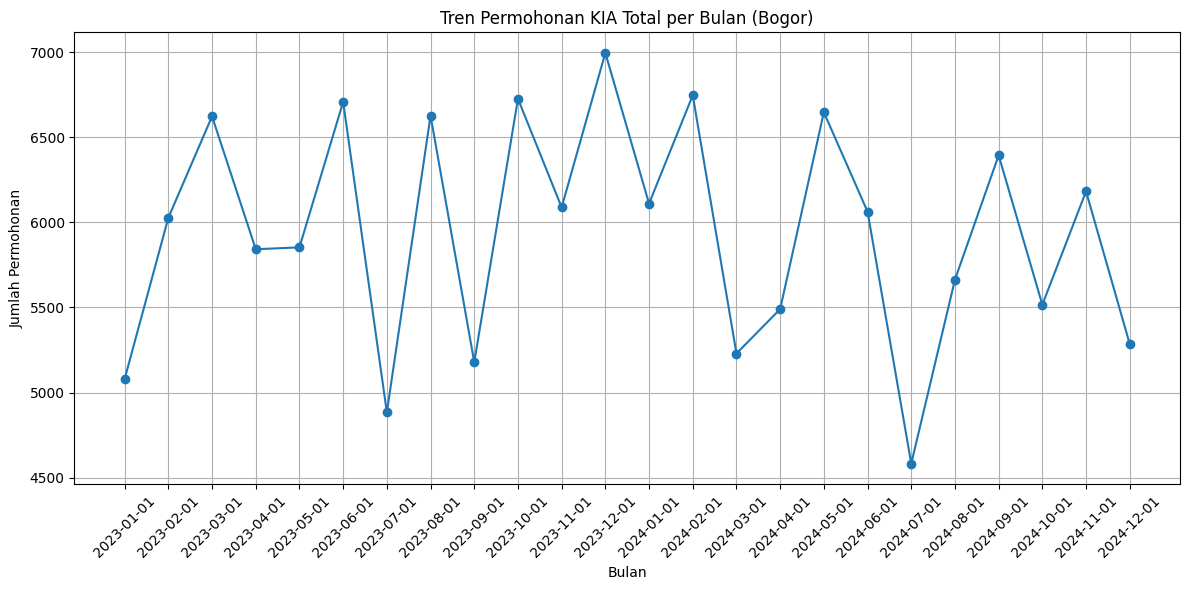

In [60]:
# 3. Plot tren jumlah permohonan total seluruh kecamatan per bulan
import matplotlib.pyplot as plt

df_group = df.groupby('Bulan')['Jumlah_Total'].sum().reset_index()
plt.figure(figsize=(12,6))
plt.plot(df_group['Bulan'], df_group['Jumlah_Total'], marker='o')
plt.title('Tren Permohonan KIA Total per Bulan (Bogor)')
plt.xticks(rotation=45)
plt.ylabel('Jumlah Permohonan')
plt.xlabel('Bulan')
plt.grid(True)
plt.tight_layout()
plt.show()

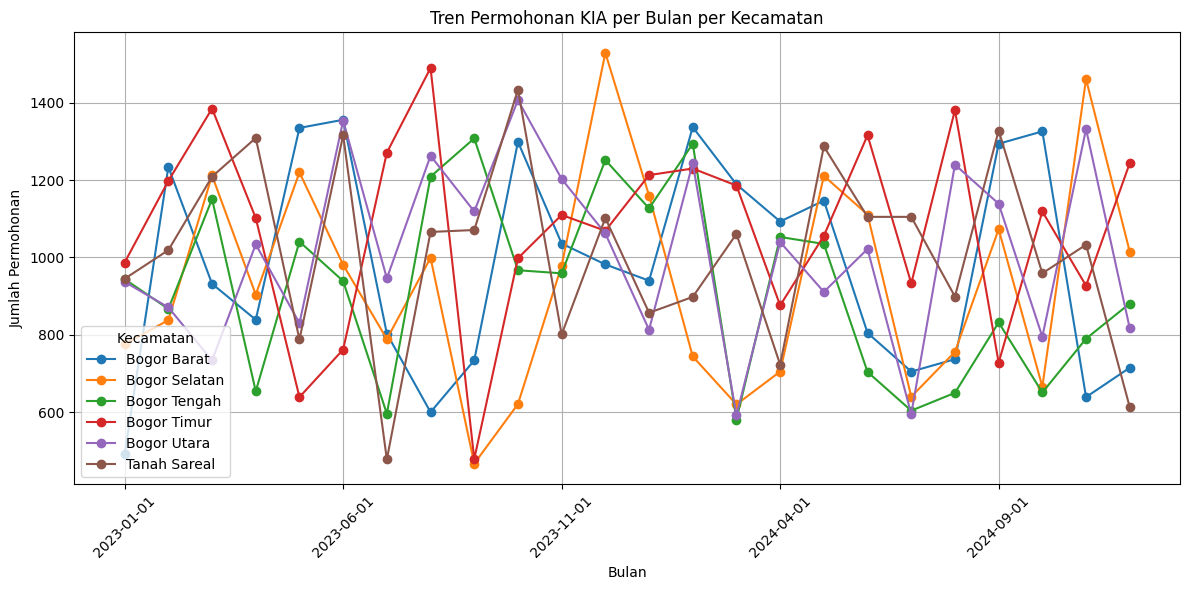

In [61]:
# 4. Plot per kecamatan
pivot_kec = df.pivot_table(index='Bulan', columns='Kecamatan', values='Jumlah_Total', aggfunc='sum')
pivot_kec.plot(figsize=(12,6), marker='o')
plt.title('Tren Permohonan KIA per Bulan per Kecamatan')
plt.xticks(rotation=45)
plt.ylabel('Jumlah Permohonan')
plt.xlabel('Bulan')
plt.grid(True)
plt.tight_layout()
plt.legend(title='Kecamatan')
plt.show()

In [62]:
# 5. Analisis per kecamatan: rata-rata, max, min jumlah permohonan
stats_kec = df.groupby('Kecamatan')['Jumlah_Total'].agg(['mean', 'max', 'min', 'std']).reset_index()
print(stats_kec)


       Kecamatan         mean   max  min         std
0    Bogor Barat   982.000000  1356  491  273.287395
1  Bogor Selatan   936.541667  1529  467  274.527100
2   Bogor Tengah   920.375000  1308  581  232.378404
3    Bogor Timur  1070.791667  1490  479  248.511391
4    Bogor Utara  1012.500000  1407  592  231.966452
5   Tanah Sareal  1016.916667  1434  478  236.529972


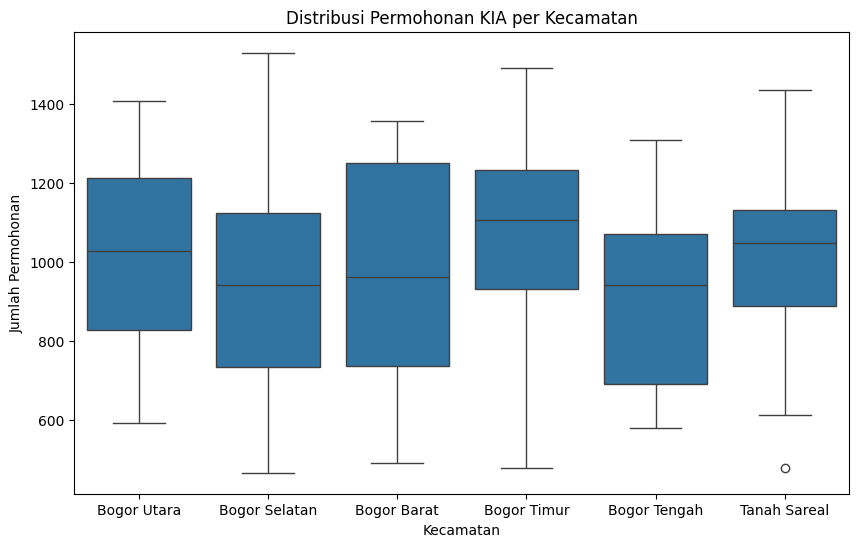

In [63]:

# 6. Visualisasi distribusi permohonan tiap kecamatan
import seaborn as sns
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='Kecamatan', y='Jumlah_Total')
plt.title('Distribusi Permohonan KIA per Kecamatan')
plt.ylabel('Jumlah Permohonan')
plt.xlabel('Kecamatan')
plt.show()


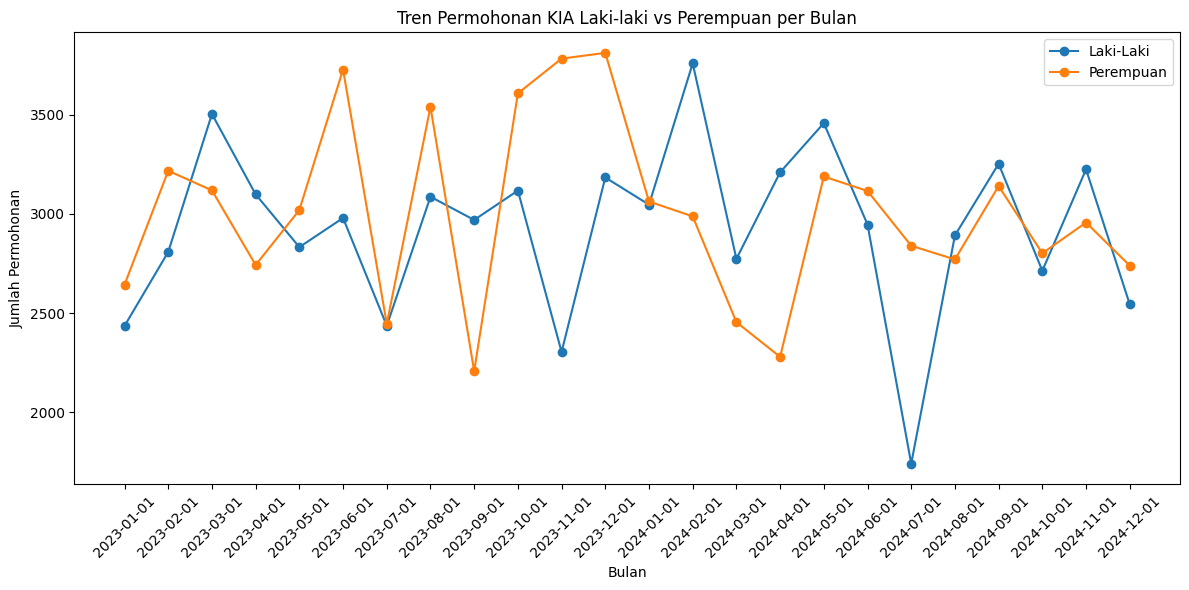

In [64]:

# 7. Visualisasi proporsi permohonan laki-laki vs perempuan
df_gender = df.groupby('Bulan')[['Jumlah_Laki_Laki', 'Jumlah_Perempuan']].sum().reset_index()
plt.figure(figsize=(12,6))
plt.plot(df_gender['Bulan'], df_gender['Jumlah_Laki_Laki'], label='Laki-Laki', marker='o')
plt.plot(df_gender['Bulan'], df_gender['Jumlah_Perempuan'], label='Perempuan', marker='o')
plt.title('Tren Permohonan KIA Laki-laki vs Perempuan per Bulan')
plt.xlabel('Bulan')
plt.ylabel('Jumlah Permohonan')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


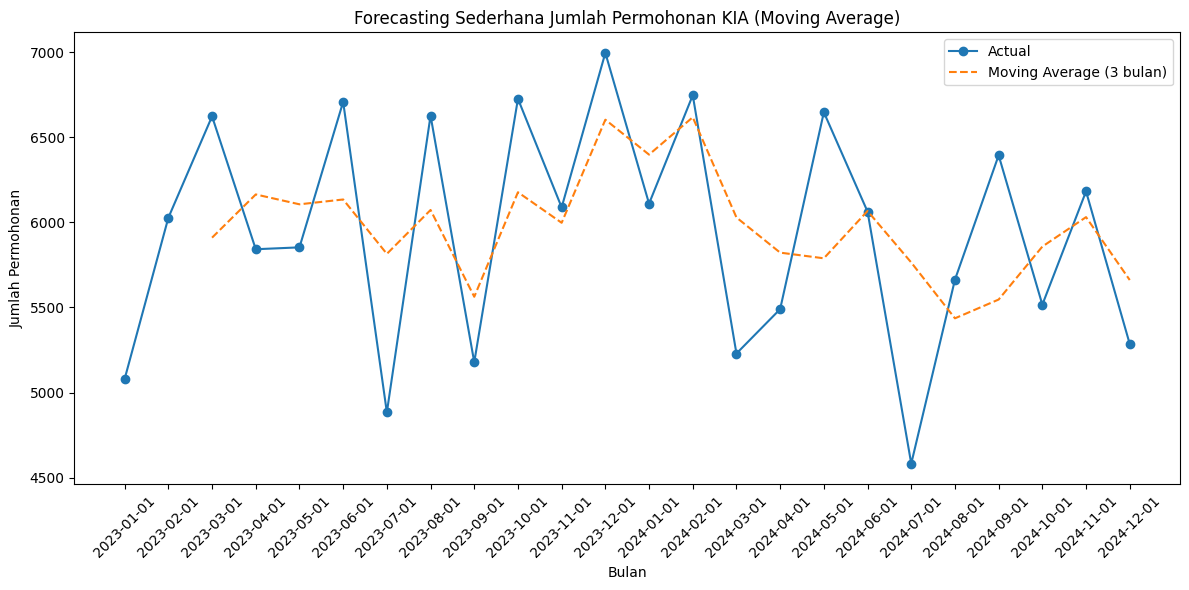

In [65]:

# 8. Forecasting sederhana: moving average 3 bulan ke depan untuk total permohonan
df_group['MA3'] = df_group['Jumlah_Total'].rolling(window=3).mean()
plt.figure(figsize=(12,6))
plt.plot(df_group['Bulan'], df_group['Jumlah_Total'], label='Actual', marker='o')
plt.plot(df_group['Bulan'], df_group['MA3'], label='Moving Average (3 bulan)', linestyle='--')
plt.title('Forecasting Sederhana Jumlah Permohonan KIA (Moving Average)')
plt.xlabel('Bulan')
plt.ylabel('Jumlah Permohonan')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Prediksi jumlah permohonan KIA untuk bulan berikutnya: 5802


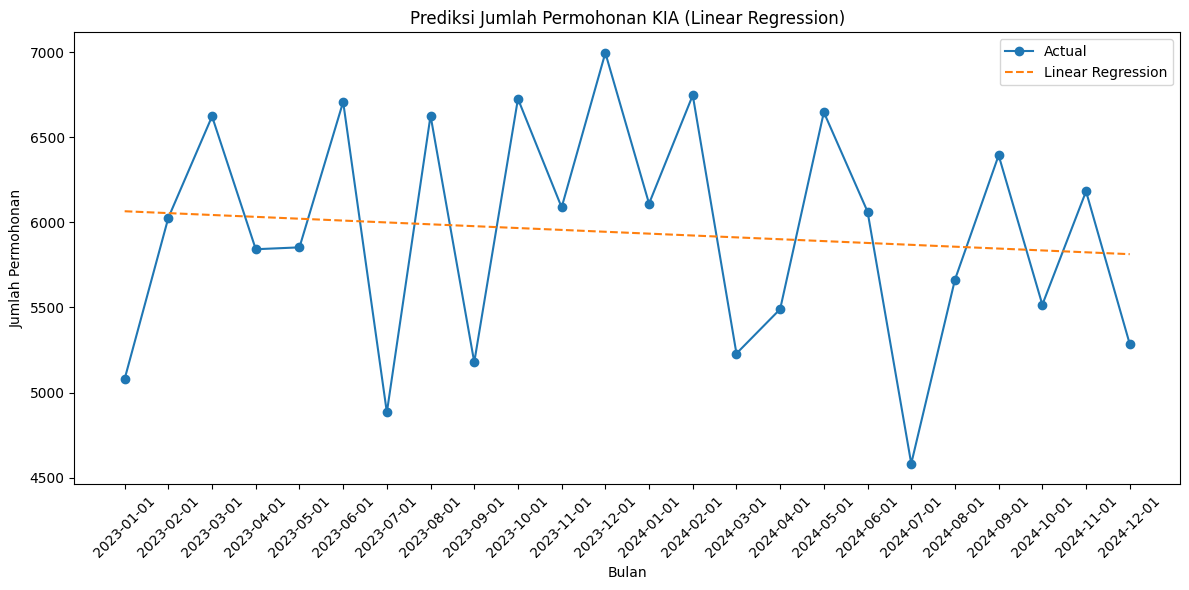

In [66]:
# 9. Prediksi Sederhana dengan Linear Regression untuk Forecasting Jumlah Permohonan di Bulan Berikutnya

from sklearn.linear_model import LinearRegression
import numpy as np

# Siapkan data untuk prediksi: gunakan indeks sebagai fitur (representasi waktu)
df_group['Bulan_int'] = np.arange(len(df_group))
X = df_group[['Bulan_int']]
y = df_group['Jumlah_Total']

# Buat dan fit model regresi
model = LinearRegression()
model.fit(X, y)

# Prediksi bulan berikutnya
next_month_int = X['Bulan_int'].max() + 1
next_month_pred = model.predict([[next_month_int]])
print(f"Prediksi jumlah permohonan KIA untuk bulan berikutnya: {int(next_month_pred[0])}")

# Visualisasi hasil prediksi linear regression
df_group['Prediksi_LinReg'] = model.predict(X)
plt.figure(figsize=(12,6))
plt.plot(df_group['Bulan'], df_group['Jumlah_Total'], label='Actual', marker='o')
plt.plot(df_group['Bulan'], df_group['Prediksi_LinReg'], label='Linear Regression', linestyle='--')
plt.title('Prediksi Jumlah Permohonan KIA (Linear Regression)')
plt.xlabel('Bulan')
plt.ylabel('Jumlah Permohonan')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



In [67]:
# 10. Simpan dataframe prediksi ke CSV
df_group.to_csv('kia_forecast_result.csv', index=False)
print("Hasil prediksi telah disimpan ke kia_forecast_result.csv")

# --- Selesai ---

Hasil prediksi telah disimpan ke kia_forecast_result.csv


In [69]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

mse = mean_squared_error(df_group['Jumlah_Total'], df_group['Prediksi_LinReg'])
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(df_group['Jumlah_Total'], df_group['Prediksi_LinReg'])

print(f"RMSE model Linear Regression: {rmse:.2f}")
print(f"MAPE model Linear Regression: {mape:.2%}")

RMSE model Linear Regression: 655.25
MAPE model Linear Regression: 9.72%


In [70]:
# 12. Prediksi ke depan (3 bulan berikutnya) dengan Linear Regression

future_months = [df_group['Bulan_int'].max() + i for i in range(1, 4)]
future_preds = model.predict(np.array(future_months).reshape(-1, 1))

# Buat label bulan untuk prediksi ke depan
import pandas as pd
last_bulan = pd.to_datetime(df_group['Bulan'].iloc[-1])
future_bulans = [(last_bulan + pd.DateOffset(months=i)).strftime('%Y-%m-%d') for i in range(1, 4)]

# Tampilkan hasil prediksi bulan depan
for bulan, pred in zip(future_bulans, future_preds):
    print(f"Prediksi jumlah permohonan KIA untuk {bulan}: {int(pred)}")



Prediksi jumlah permohonan KIA untuk 2025-01-01: 5802
Prediksi jumlah permohonan KIA untuk 2025-02-01: 5791
Prediksi jumlah permohonan KIA untuk 2025-03-01: 5780


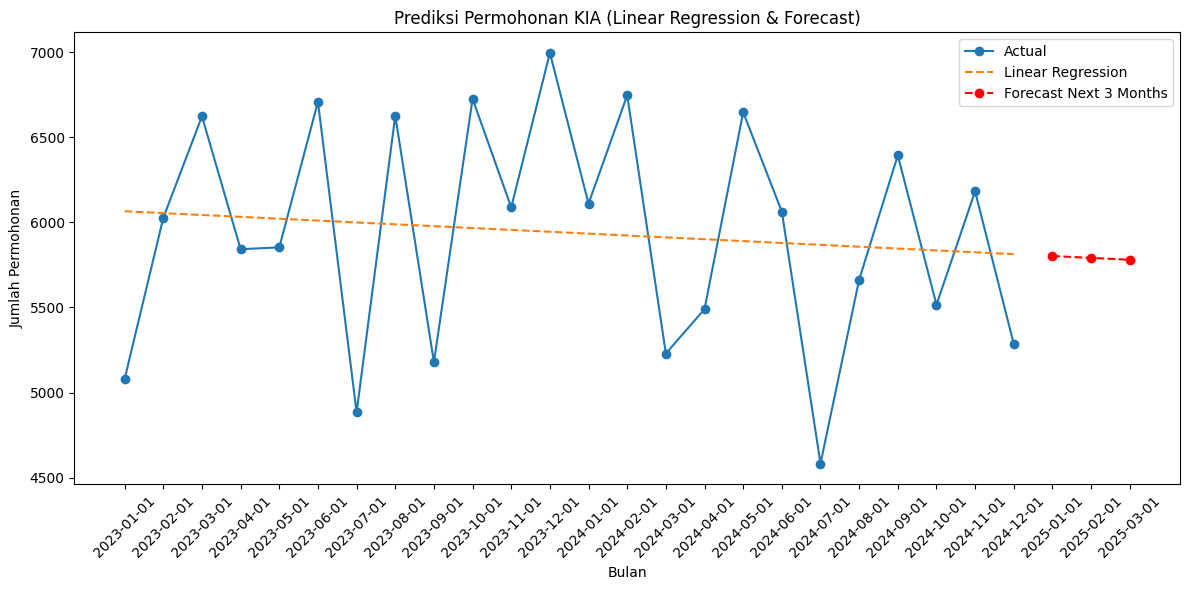

In [71]:
# 13. Visualisasi hasil prediksi ke depan
plt.figure(figsize=(12,6))
plt.plot(df_group['Bulan'], df_group['Jumlah_Total'], label='Actual', marker='o')
plt.plot(df_group['Bulan'], df_group['Prediksi_LinReg'], label='Linear Regression', linestyle='--')
plt.plot(future_bulans, future_preds, 'ro--', label='Forecast Next 3 Months')
plt.title('Prediksi Permohonan KIA (Linear Regression & Forecast)')
plt.xlabel('Bulan')
plt.ylabel('Jumlah Permohonan')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [73]:
# 14. Modeling Prediksi Time Series dengan Prophet (Facebook Prophet)

from prophet import Prophet

# Siapkan data untuk Prophet (kolom harus: ds (tanggal), y (nilai))
df_prophet = df_group[['Bulan', 'Jumlah_Total']].copy()
df_prophet.rename(columns={'Bulan': 'ds', 'Jumlah_Total': 'y'}, inplace=True)

# Prophet butuh format tanggal, bukan string
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])


INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8typtag8/c48dssnr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8typtag8/ssp_ktue.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16006', 'data', 'file=/tmp/tmp8typtag8/c48dssnr.json', 'init=/tmp/tmp8typtag8/ssp_ktue.json', 'output', 'file=/tmp/tmp8typtag8/prophet_modeldhac_hdh/prophet_model-20250806090223.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:02:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:02:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


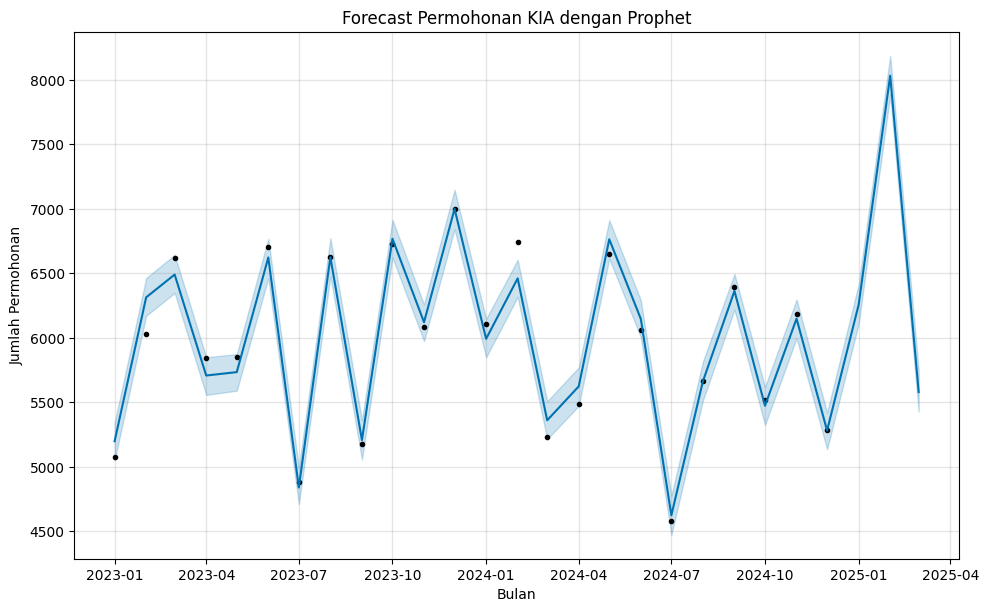

In [74]:

# Inisialisasi dan fit model Prophet
model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model_prophet.fit(df_prophet)

# Buat data future (3 bulan ke depan)
future = model_prophet.make_future_dataframe(periods=3, freq='MS')
forecast = model_prophet.predict(future)

# Visualisasi hasil prediksi Prophet
fig1 = model_prophet.plot(forecast)
plt.title('Forecast Permohonan KIA dengan Prophet')
plt.xlabel('Bulan')
plt.ylabel('Jumlah Permohonan')
plt.show()


In [76]:

# Tampilkan prediksi 3 bulan ke depan
future_forecast = forecast.tail(3)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
print("Prediksi jumlah permohonan KIA (Prophet) untuk 3 bulan ke depan:")
print(future_forecast)


Prediksi jumlah permohonan KIA (Prophet) untuk 3 bulan ke depan:
           ds         yhat   yhat_lower   yhat_upper
24 2025-01-01  6256.608119  6108.962651  6415.238892
25 2025-02-01  8033.491337  7883.777283  8186.277327
26 2025-03-01  5579.585981  5427.195234  5745.689101


In [78]:
# Simpan hasil prediksi Prophet ke CSV
forecast.to_csv('kia_forecast_prophet.csv', index=False)
print("Hasil prediksi Prophet telah disimpan ke kia_forecast_prophet.csv")

Hasil prediksi Prophet telah disimpan ke kia_forecast_prophet.csv
